In [100]:
# Add project root to sys.path
import sys
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver 


In [101]:
sys.path.append(r"c:\telia\LLMOPS_PROJ\AUTOMATED-RESEARCH-REPORT-GENERATION")

In [102]:
from research_and_analyst.utils.model_loader import ModelLoader

In [103]:
model_loader = ModelLoader()

{"timestamp": "2025-10-27T22:03:52.685107Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T22:03:52.698114Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T22:03:52.702122Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}


{"timestamp": "2025-10-27T22:03:52.705204Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-27T22:03:52.708124Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-27T22:03:52.711117Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-27T22:03:52.758959Z", "level": "info", "event": "YAML config loaded"}


In [104]:
llm = model_loader.load_llm()


{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-27T22:04:00.017373Z", "level": "info", "event": "Loading LLM"}


In [106]:
example= llm.invoke("Hello, how are you?")

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [117]:
print(example.response_metadata["model_name"])

gpt-4o-2024-08-06


In [118]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [119]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [121]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [122]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [123]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [125]:
example = Analyst(
    name="Alice Johnson",
    role="Economic Analyst",
    affiliation="Global Finance Institute",
    description="Focuses on global economic trends and their impact on markets."   
    )

In [126]:
print(example.persona)

Name: Alice Johnson
Role: Economic Analyst
Affiliation: Global Finance Institute
Description: Focuses on global economic trends and their impact on markets.



In [129]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [130]:
GenerateAnalystsState(
    topic="Finance and Economy",
    max_analysts=3,
    human_analyst_feedback="give the real info"
)

{'topic': 'Finance and Economy',
 'max_analysts': 3,
 'human_analyst_feedback': 'give the real info'}

In [24]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [131]:
print(
    [analyst_instructions.format
     (
         topic="education",
         max_analysts=3,
         human_analyst_feedback="give the real info"
     )] + ["Generate the set of analysts."]
)

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\ngive the real info\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 3 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [132]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    
    

In [133]:
print(create_analyst(
    {
        "topic": "Finance and Economy",
        "max_analysts": 3,
        "human_analyst_feedback": "give the real info"
    }
))

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Economic Policy Analyst', affiliation='International Monetary Fund (IMF)', description="Dr. Chen focuses on the impact of fiscal and monetary policies on global economic stability. She is particularly concerned with how different countries' policy decisions affect international trade and economic growth. Her motive is to provide insights that help stabilize economies and promote sustainable growth."), Analyst(name='Michael Thompson', role='Financial Markets Analyst', affiliation='Goldman Sachs', description='Michael specializes in analyzing trends in global financial markets, including stock, bond, and commodity markets. His primary concern is understanding how geopolitical events and economic indicators influence market movements. He aims to provide actionable insights for investors to make informed decisions.'), Analyst(name='Sofia Martinez', role='Cryptocurrency and Blockchain Analyst', affiliation='CoinDesk', description='Sofia is 

In [134]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [135]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [174]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver  

In [136]:
from IPython.display import display, Image

In [137]:
builder = StateGraph(GenerateAnalystsState)


In [138]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [139]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])


In [140]:
memory = MemorySaver()

In [149]:
print(type(memory))


<class 'langgraph.checkpoint.memory.InMemorySaver'>


In [ ]:
# Print all attributes and methods
print(dir(memory))

In [ ]:
# Print all attributes and methods
print(dir(memory))
for name in dir(memory):
    attr = getattr(memory, name)
    print(f"{name}: {type(attr)}")

In [158]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)   

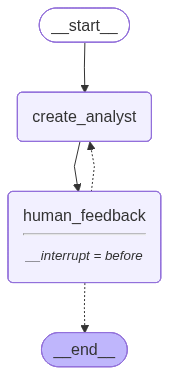

In [142]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [170]:
topic = "Impact of AI on solar industry"


In [171]:
max_analysts = 3


In [ ]:
thread =  {"configurable":{"thread_id":1}}


In [173]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    for key, value in event.items():
        print(f"{key}: {value}")
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

topic: Impact of AI on solar industry
max_analysts: 3


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


topic: Impact of AI on solar industry
max_analysts: 3
analysts: [Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'), Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, and equitable access. He is drive

In [176]:
for thread_id, states in memory.storage.items():
    print(f"Thread ID: {thread_id}------ states: {len(states)}")
    for idx, state in enumerate(states):
        print(f"  State {idx}: {state}")

Thread ID: 1------ states: 1
  State 0: 
Thread ID: 2------ states: 1
  State 0: 


In [182]:
thread =  {"configurable":{"thread_id":2}}

In [183]:
state = graph.get_state(thread)


In [184]:
state


StateSnapshot(values={'topic': 'Impact of AI on solar industry', 'max_analysts': 3, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'), Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, a

In [185]:
print(state.values.get('analysts'))

[Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'), Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, and equitable access. He is driven by the need to create frameworks that guide the ethical use of

In [186]:
print(state.values.keys())

dict_keys(['topic', 'max_analysts', 'analysts'])


In [187]:
state.values

{'topic': 'Impact of AI on solar industry',
 'max_analysts': 3,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'),
  Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, and equitable acce

In [47]:
memory.storage.items()


dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0b1243-a3b2-6489-bfff-3906d3e657cc': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-24T21:56:00.237888+00:00\xa2id\xd9$1f0b1243-a3b2-6489-bfff-3906d3e657cc\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.13744093641927357\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0b1243-a3ba-6e7a-8000-4aab55f29b8d': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-24T21:56:00.241420+00:00\xa2id\xd9$1f0b1243-a3ba-6e7a-8000-4aab55f29b8d\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.2647344009858734\xa5topic\xd9300000000000000000000000000000002.0.2647344009858734\xacmax_analysts\xd9300000000000000000000000000000002.0.2647344009858734\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.2647344009858734\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [188]:
state.config


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b5d7b-b03e-6a85-8001-4f56c6280d16'}}

In [49]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [189]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config
print(cfg)

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b5d7b-b03e-6a85-8001-4f56c6280d16'}}


In [191]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": "Change topic to cricket"}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b5dc5-df5d-6954-8002-cacda35012cb'}}

In [192]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

('create_analyst',)


In [193]:
analysts = final_state.values.get('analysts')


In [194]:
analysts


[Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'),
 Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, and equitable access. He is driven by the need to create frameworks that guide the ethical use o

In [195]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: International Renewable Energy Agency (IRENA)
Role: AI and Renewable Energy Specialist
Description: Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.
--------------------------------------------------
Name: Raj Patel
Affiliation: Center for AI Policy and Ethics
Role: AI Ethics and Policy Analyst
Description: Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, and equitable access. He is driven by the need to create frameworks that guide

In [118]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a6e6e-a40b-6ce8-8001-3bc7b7630aea'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-11T21:11:55.128548+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a6e6e-7d57-603f-8000-6bd26ca8df66'}}, tasks=(PregelTask(id='be40aec7-e16f-86b3-4257-e9c4f915c312', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [119]:
state.values


{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4}

Second Workflow


In [196]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [197]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [199]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [201]:
tavily_search.invoke("What is new deal between Nvidia and Nokia")


[{'title': 'NVIDIA and Nokia to Pioneer the AI Platform for 6G',
  'url': 'https://nvidianews.nvidia.com/news/nvidia-nokia-ai-telecommunications',
  'content': 'GTC Washington, D.C.—NVIDIA and Nokia today announced a strategic partnership to add NVIDIA-powered, commercial-grade AI-RAN products to Nokia’s industry-leading RAN portfolio, enabling communication service providers to launch AI-native 5G-Advanced and 6G networks on NVIDIA platforms. NVIDIA will also invest $1 billion in Nokia at a subscription price of $6.01 per share. The investment is subject to customary closing conditions. [...] NVIDIA and Nokia to establish a strategic partnership to enable accelerated development and deployment of next generation AI native mobile networks and AI networking infrastructure.\n   NVIDIA introduces NVIDIA Arc Aerial RAN Computer, a 6G-ready telecommunications computing platform.\n   Nokia to expand its global access portfolio with new AI-RAN product based on NVIDIA platform. [...] Nokia wil

In [202]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [203]:
from typing import Annotated
import operator
from langgraph.graph import MessagesState
class InterviewState(MessagesState):
    max_num_turns: int #Number turns of converstation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list  # Final key we duplicate in outer state of Send() API
    
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query to be sent to search engine")

In [62]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [204]:
print(len(analysts))


3


In [205]:
print(question_instructions.format(goals = analyst.persona))


You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: Name: Sofia Martinez
Role: Economic Impact Analyst
Affiliation: Global Energy Economics Institute
Description: Sofia Martinez analyzes the economic impacts of AI integration in the solar industry. Her work involves assessing how AI-driven innovations can influence market dynamics, job creation, and investment in solar technologies. She is particularly interested in how AI can lower costs and increase the competitiveness of solar energy, thereby influencing global energy markets.


Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to d

In [211]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    print(f"Yes i am checking messages  {messages} ")
    print(f"Yes i am checking analyst  {analyst.persona} ")
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    print(f"Generated question  ---->: {question.content}")
    #returen the question through state
    return {"messages":[question]}

In [212]:
print(analyst.persona)

Name: Sofia Martinez
Role: Economic Impact Analyst
Affiliation: Global Energy Economics Institute
Description: Sofia Martinez analyzes the economic impacts of AI integration in the solar industry. Her work involves assessing how AI-driven innovations can influence market dynamics, job creation, and investment in solar technologies. She is particularly interested in how AI can lower costs and increase the competitiveness of solar energy, thereby influencing global energy markets.



In [214]:
sample_state = {
    "max_num_turns": 2,
    "context": [],
    "analyst": analyst,
    "interview": "",
    "sections": [],
    "messages": [HumanMessage(content="What are the latest trends in Solar Industry?")]
}

result = generation_question(sample_state)
print(result)

Yes i am checking messages  [HumanMessage(content='What are the latest trends in Solar Industry?', additional_kwargs={}, response_metadata={})] 
Yes i am checking analyst  Name: Sofia Martinez
Role: Economic Impact Analyst
Affiliation: Global Energy Economics Institute
Description: Sofia Martinez analyzes the economic impacts of AI integration in the solar industry. Her work involves assessing how AI-driven innovations can influence market dynamics, job creation, and investment in solar technologies. She is particularly interested in how AI can lower costs and increase the competitiveness of solar energy, thereby influencing global energy markets.
 


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated question  ---->: Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?
{'messages': [AIMessage(content="Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 249, 'total_tokens': 314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'r

In [ ]:
{'messages': [AIMessage(content="Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 249, 'total_tokens': 314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWWAt3Si9MvcyIG6KmV3dvEVVnzdT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5db45eb-0caa-4f07-8a69-7d7f3d9bedc7-0', usage_metadata={'input_tokens': 249, 'output_tokens': 65, 'total_tokens': 314, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [210]:
print(state)

StateSnapshot(values={'topic': 'Impact of AI on solar industry', 'max_analysts': 3, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI and Renewable Energy Specialist', affiliation='International Renewable Energy Agency (IRENA)', description='Dr. Chen focuses on the integration of AI technologies in renewable energy systems, particularly solar power. Her primary concern is how AI can optimize solar energy production and distribution, making it more efficient and cost-effective. She is motivated by the potential of AI to accelerate the transition to sustainable energy sources and reduce carbon emissions globally.'), Analyst(name='Raj Patel', role='AI Ethics and Policy Analyst', affiliation='Center for AI Policy and Ethics', description='Raj Patel examines the ethical implications and policy challenges of deploying AI in the solar industry. His focus is on ensuring that AI applications in solar energy are developed and used responsibly, with considerations for privacy, data security, a

In [215]:
from langchain_core.messages import get_buffer_string


In [208]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [209]:
def ask_question(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [225]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    #print(f"structure_llm: {structure_llm}")
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    #<print(dir(search_query))
    # Search
    print(f"Search Query  ---> : {search_query.search_query}")
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    print(f"Search Docs  -----> : {search_docs}")
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [226]:
sample_state2 = {
    "max_num_turns": 2,
    "context": [],
    "analyst": analyst,
    "interview": "",
    "sections": [],
    "messages": [AIMessage(content="Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 249, 'total_tokens': 314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWWAt3Si9MvcyIG6KmV3dvEVVnzdT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5db45eb-0caa-4f07-8a69-7d7f3d9bedc7-0', usage_metadata={'input_tokens': 249, 'output_tokens': 65, 'total_tokens': 314, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
}

result = search_web(sample_state2)
print(result)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Search Query  ---> : economic impacts of AI integration in the solar industry 2023
Search Docs  -----> : [{'title': 'Solar AI: A New Era of Efficiency - Sunlead', 'url': 'https://getsunlead.com/articles/solar-ai-innovations', 'content': 'Back to Articles\n\n## Solar AI: A New Era of Efficiency\n\nSolar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.\n Reduced Cost: By automating tasks and predicting maintenan

In [ ]:
{'context': ['<Document href="https://getsunlead.com/articles/solar-ai-innovations"/>\nBack to Articles\n\n## Solar AI: A New Era of Efficiency\n\nSolar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.\n Reduced Cost: By automating tasks and predicting maintenance needs, Solar AI  will reduce the need for manual labor and help to prevent costly repairs. It can help both companies and customers to save money. [...] 3. Integration Issues: Solar companies may face issues integrating AI with existing solar technologies. Integration may be complex, or new AI tools may be incompatible with the existing systems.\n\nConsideration: The companies would have to perform a thorough compatibility analysis and may even have to upgrade or alter the existing systems.\n</Document>\n\n---\n\n<Document href="https://www.linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc"/>\nThe Solar AI market is projected to reach USD 4,689 million by 2033, rising from USD 1,098 million in 2023, growing at a CAGR of 17.5% over the forecast period.\n   Machine Learning dominates the technology landscape in Solar AI, securing a 49.2% market share due to its efficiency in predictive maintenance and solar forecasting.\n   Within applications, Energy Management leads the segment with over 34.5% share, driven by demand for smart grid optimization and consumption analytics. [...] In March 2023, Sarcos Technology and Robotics Corporation secured USD 1.9 million in funding from the U.S. Department of Energy to develop a robotic system designed to automate and optimize the construction of solar power plants. This initiative reflects a growing shift toward integrating robotics in large-scale renewable infrastructure projects. [...] The integration of Artificial Intelligence (AI) in solar energy systems is leading to significant transformations. One notable trend is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules.\n</Document>\n\n---\n\n<Document href="https://www.grandviewresearch.com/industry-analysis/solar-ai-market-report"/>\nThe global solar AI market size was estimated at USD 5.96 billion in 2024 and is projected to grow at a CAGR of 20.8% from 2025 to 2030. AI integration into solar design platforms is accelerating as companies work to automate and enhance the solar project lifecycle. With AI, design platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This integration reduces the time needed for manual surveys and [...] North America solar AI market dominated the global industry and accounted for a 36.8% share in 2024. The solar AI market in North America is experiencing rapid growth, driven by an increasing focus on clean energy solutions and grid modernization. The integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. With strong government incentives and a growing renewable energy infrastructure, the market is expected to [...] AI models are significantly transforming the solar energy industry by improving forecasting accuracy, which is crucial for optimizing energy production and consumption. By integrating real-time weather data with historical energy trends, these models provide more precise predictions about solar energy generation. This enhanced forecasting allows grid operators to better manage the distribution and storage of energy, ensuring that supply meets demand efficiently. As solar energy is intermittent,\n</Document>\n\n---\n\n<Document href="https://www.weforum.org/stories/2024/08/how-ai-can-help-revolutionize-solar-power/"/>\nAs AI accelerates in importance to people and the economy, its significant energy demand and consequent environmental impact is also drawing attention.\n Integrating AI into renewable energy generation — particularly solar power — could improve efficiency to offset the tech\'s demands on the power grid and associated emissions.\n Already, use cases like predictive maintenance and AI-enabled trading are emerging as ways AI can improve the deployment of solar power. [...] But AI itself might offer a solution. Advancements in renewable energy, paired with AI, could sustainably meet the increased energy demand. One promising path is integrating AI into the growing market of solar energy systems that offer clean and affordable energy to grid systems. According to the IEA, power sector investment in solar photovoltaic (PV) technology is projected to exceed $500 billion in 2024, surpassing all other generation sources combined.\n</Document>\n\n---\n\n<Document href="https://codewave.com/insights/ai-enhancing-solar-energy-innovations-trends/"/>\n## Why Do Solar and AI Make a Good Pair?\n\nSolar AI market in the U.S. is expected to see sustained double-digit growth, with the global Solar AI market forecast to reach $4.7 billion by 2033. You’ve dealt with panels underperforming after a cloudy week or surprise repair bills eating into your margins. By tapping into AI in solar energy, you feed live weather and panel data into models that flag trouble before it costs you. [...] ## Future Trends in AI and Solar Integration\n\nAI in solar energy isn’t standing still, it’s moving from basic monitoring to systems that think, predict, and act on their own. We’re seeing early signs of this shift in real-world pilots, backed by government funding and academic research.\n\nFrom AI speeding up grid interconnections to agentic digital twins that plan ahead, the future is pointing toward smarter, more self-reliant operations. [...] What you gain: better use of stored energy, smarter grid exports, and stronger revenue from the same capacity.\n\nBusiness Impact Metrics\n\nWant to show the numbers? Start tracking:\n\n Uptime gains from earlier fault detection\n Maintenance cost per kWh saved through smarter crew dispatch\n ROI on battery investments based on optimized discharge cycles\n</Document>']}

In [71]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [72]:
result = search_web(state)


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [227]:
print(result["context"][0])


<Document href="https://getsunlead.com/articles/solar-ai-innovations"/>
Back to Articles

## Solar AI: A New Era of Efficiency

Solar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.
 Reduced Cost: By automating tasks and predicting maintenance needs, Solar AI  will reduce the need for manual labor and help to prevent costly repairs. It can help both companies and customers to save money. [...] 3. Integration 

In [229]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [230]:
sample_state2 = {
    "max_num_turns": 2,
    "context": [],
    "analyst": analyst,
    "interview": "",
    "sections": [],
    "messages": [AIMessage(content="Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 249, 'total_tokens': 314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWWAt3Si9MvcyIG6KmV3dvEVVnzdT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5db45eb-0caa-4f07-8a69-7d7f3d9bedc7-0', usage_metadata={'input_tokens': 249, 'output_tokens': 65, 'total_tokens': 314, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
}

result = search_wikipedia(sample_state2)
print(result)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'context': ['<Document source="https://en.wikipedia.org/wiki/Artificial_intelligence" page=""/>\nArtificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived

In [75]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [76]:
result = search_wikipedia(state)


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [77]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()


In [78]:
search_docs


[]

In [79]:
result


{'context': ['']}

In [81]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [82]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [231]:
sample_state3 = {
    "max_num_turns": 2,
    "context": ['<Document href="https://getsunlead.com/articles/solar-ai-innovations"/>\nBack to Articles\n\n## Solar AI: A New Era of Efficiency\n\nSolar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.\n Reduced Cost: By automating tasks and predicting maintenance needs, Solar AI  will reduce the need for manual labor and help to prevent costly repairs. It can help both companies and customers to save money. [...] 3. Integration Issues: Solar companies may face issues integrating AI with existing solar technologies. Integration may be complex, or new AI tools may be incompatible with the existing systems.\n\nConsideration: The companies would have to perform a thorough compatibility analysis and may even have to upgrade or alter the existing systems.\n</Document>\n\n---\n\n<Document href="https://www.linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc"/>\nThe Solar AI market is projected to reach USD 4,689 million by 2033, rising from USD 1,098 million in 2023, growing at a CAGR of 17.5% over the forecast period.\n   Machine Learning dominates the technology landscape in Solar AI, securing a 49.2% market share due to its efficiency in predictive maintenance and solar forecasting.\n   Within applications, Energy Management leads the segment with over 34.5% share, driven by demand for smart grid optimization and consumption analytics. [...] In March 2023, Sarcos Technology and Robotics Corporation secured USD 1.9 million in funding from the U.S. Department of Energy to develop a robotic system designed to automate and optimize the construction of solar power plants. This initiative reflects a growing shift toward integrating robotics in large-scale renewable infrastructure projects. [...] The integration of Artificial Intelligence (AI) in solar energy systems is leading to significant transformations. One notable trend is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules.\n</Document>\n\n---\n\n<Document href="https://www.grandviewresearch.com/industry-analysis/solar-ai-market-report"/>\nThe global solar AI market size was estimated at USD 5.96 billion in 2024 and is projected to grow at a CAGR of 20.8% from 2025 to 2030. AI integration into solar design platforms is accelerating as companies work to automate and enhance the solar project lifecycle. With AI, design platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This integration reduces the time needed for manual surveys and [...] North America solar AI market dominated the global industry and accounted for a 36.8% share in 2024. The solar AI market in North America is experiencing rapid growth, driven by an increasing focus on clean energy solutions and grid modernization. The integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. With strong government incentives and a growing renewable energy infrastructure, the market is expected to [...] AI models are significantly transforming the solar energy industry by improving forecasting accuracy, which is crucial for optimizing energy production and consumption. By integrating real-time weather data with historical energy trends, these models provide more precise predictions about solar energy generation. This enhanced forecasting allows grid operators to better manage the distribution and storage of energy, ensuring that supply meets demand efficiently. As solar energy is intermittent,\n</Document>\n\n---\n\n<Document href="https://www.weforum.org/stories/2024/08/how-ai-can-help-revolutionize-solar-power/"/>\nAs AI accelerates in importance to people and the economy, its significant energy demand and consequent environmental impact is also drawing attention.\n Integrating AI into renewable energy generation — particularly solar power — could improve efficiency to offset the tech\'s demands on the power grid and associated emissions.\n Already, use cases like predictive maintenance and AI-enabled trading are emerging as ways AI can improve the deployment of solar power. [...] But AI itself might offer a solution. Advancements in renewable energy, paired with AI, could sustainably meet the increased energy demand. One promising path is integrating AI into the growing market of solar energy systems that offer clean and affordable energy to grid systems. According to the IEA, power sector investment in solar photovoltaic (PV) technology is projected to exceed $500 billion in 2024, surpassing all other generation sources combined.\n</Document>\n\n---\n\n<Document href="https://codewave.com/insights/ai-enhancing-solar-energy-innovations-trends/"/>\n## Why Do Solar and AI Make a Good Pair?\n\nSolar AI market in the U.S. is expected to see sustained double-digit growth, with the global Solar AI market forecast to reach $4.7 billion by 2033. You’ve dealt with panels underperforming after a cloudy week or surprise repair bills eating into your margins. By tapping into AI in solar energy, you feed live weather and panel data into models that flag trouble before it costs you. [...] ## Future Trends in AI and Solar Integration\n\nAI in solar energy isn’t standing still, it’s moving from basic monitoring to systems that think, predict, and act on their own. We’re seeing early signs of this shift in real-world pilots, backed by government funding and academic research.\n\nFrom AI speeding up grid interconnections to agentic digital twins that plan ahead, the future is pointing toward smarter, more self-reliant operations. [...] What you gain: better use of stored energy, smarter grid exports, and stronger revenue from the same capacity.\n\nBusiness Impact Metrics\n\nWant to show the numbers? Start tracking:\n\n Uptime gains from earlier fault detection\n Maintenance cost per kWh saved through smarter crew dispatch\n ROI on battery investments based on optimized discharge cycles\n</Document>'],
    "analyst": analyst,
    "interview": "",
    "sections": [],
    "messages": [AIMessage(content="Hello Sofia, my name is Alex Johnson, and I'm keen to delve into the economic impacts of AI integration in the solar industry. Given your expertise, could you share some insights on how AI-driven innovations are currently influencing market dynamics within the solar sector? Specifically, are there any non-obvious trends or developments that are emerging?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 249, 'total_tokens': 314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWWAt3Si9MvcyIG6KmV3dvEVVnzdT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5db45eb-0caa-4f07-8a69-7d7f3d9bedc7-0', usage_metadata={'input_tokens': 249, 'output_tokens': 65, 'total_tokens': 314, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
}

result = generate_answer(sample_state3)
print(result)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [AIMessage(content='Certainly, Sofia. AI-driven innovations are significantly influencing market dynamics in the solar industry in several ways. One of the key trends is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules. This not only reduces downtime but also lowers maintenance costs, making solar energy more competitive [2].\n\nAnother emerging trend is the integration of AI into solar design platforms. These platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This reduces the time needed for manual surveys and accelerates the solar project lifecycle, thereby increasing efficiency and reducing costs [3].\n\nAI is also playing a crucial role in energy management, particularly in optimizing smart grid operations and consumption analytics. This 

In [232]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [84]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [233]:
sample_state4 = {
    "max_num_turns": 2,
    "context": ['<Document href="https://getsunlead.com/articles/solar-ai-innovations"/>\nBack to Articles\n\n## Solar AI: A New Era of Efficiency\n\nSolar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.\n Reduced Cost: By automating tasks and predicting maintenance needs, Solar AI  will reduce the need for manual labor and help to prevent costly repairs. It can help both companies and customers to save money. [...] 3. Integration Issues: Solar companies may face issues integrating AI with existing solar technologies. Integration may be complex, or new AI tools may be incompatible with the existing systems.\n\nConsideration: The companies would have to perform a thorough compatibility analysis and may even have to upgrade or alter the existing systems.\n</Document>\n\n---\n\n<Document href="https://www.linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc"/>\nThe Solar AI market is projected to reach USD 4,689 million by 2033, rising from USD 1,098 million in 2023, growing at a CAGR of 17.5% over the forecast period.\n   Machine Learning dominates the technology landscape in Solar AI, securing a 49.2% market share due to its efficiency in predictive maintenance and solar forecasting.\n   Within applications, Energy Management leads the segment with over 34.5% share, driven by demand for smart grid optimization and consumption analytics. [...] In March 2023, Sarcos Technology and Robotics Corporation secured USD 1.9 million in funding from the U.S. Department of Energy to develop a robotic system designed to automate and optimize the construction of solar power plants. This initiative reflects a growing shift toward integrating robotics in large-scale renewable infrastructure projects. [...] The integration of Artificial Intelligence (AI) in solar energy systems is leading to significant transformations. One notable trend is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules.\n</Document>\n\n---\n\n<Document href="https://www.grandviewresearch.com/industry-analysis/solar-ai-market-report"/>\nThe global solar AI market size was estimated at USD 5.96 billion in 2024 and is projected to grow at a CAGR of 20.8% from 2025 to 2030. AI integration into solar design platforms is accelerating as companies work to automate and enhance the solar project lifecycle. With AI, design platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This integration reduces the time needed for manual surveys and [...] North America solar AI market dominated the global industry and accounted for a 36.8% share in 2024. The solar AI market in North America is experiencing rapid growth, driven by an increasing focus on clean energy solutions and grid modernization. The integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. With strong government incentives and a growing renewable energy infrastructure, the market is expected to [...] AI models are significantly transforming the solar energy industry by improving forecasting accuracy, which is crucial for optimizing energy production and consumption. By integrating real-time weather data with historical energy trends, these models provide more precise predictions about solar energy generation. This enhanced forecasting allows grid operators to better manage the distribution and storage of energy, ensuring that supply meets demand efficiently. As solar energy is intermittent,\n</Document>\n\n---\n\n<Document href="https://www.weforum.org/stories/2024/08/how-ai-can-help-revolutionize-solar-power/"/>\nAs AI accelerates in importance to people and the economy, its significant energy demand and consequent environmental impact is also drawing attention.\n Integrating AI into renewable energy generation — particularly solar power — could improve efficiency to offset the tech\'s demands on the power grid and associated emissions.\n Already, use cases like predictive maintenance and AI-enabled trading are emerging as ways AI can improve the deployment of solar power. [...] But AI itself might offer a solution. Advancements in renewable energy, paired with AI, could sustainably meet the increased energy demand. One promising path is integrating AI into the growing market of solar energy systems that offer clean and affordable energy to grid systems. According to the IEA, power sector investment in solar photovoltaic (PV) technology is projected to exceed $500 billion in 2024, surpassing all other generation sources combined.\n</Document>\n\n---\n\n<Document href="https://codewave.com/insights/ai-enhancing-solar-energy-innovations-trends/"/>\n## Why Do Solar and AI Make a Good Pair?\n\nSolar AI market in the U.S. is expected to see sustained double-digit growth, with the global Solar AI market forecast to reach $4.7 billion by 2033. You’ve dealt with panels underperforming after a cloudy week or surprise repair bills eating into your margins. By tapping into AI in solar energy, you feed live weather and panel data into models that flag trouble before it costs you. [...] ## Future Trends in AI and Solar Integration\n\nAI in solar energy isn’t standing still, it’s moving from basic monitoring to systems that think, predict, and act on their own. We’re seeing early signs of this shift in real-world pilots, backed by government funding and academic research.\n\nFrom AI speeding up grid interconnections to agentic digital twins that plan ahead, the future is pointing toward smarter, more self-reliant operations. [...] What you gain: better use of stored energy, smarter grid exports, and stronger revenue from the same capacity.\n\nBusiness Impact Metrics\n\nWant to show the numbers? Start tracking:\n\n Uptime gains from earlier fault detection\n Maintenance cost per kWh saved through smarter crew dispatch\n ROI on battery investments based on optimized discharge cycles\n</Document>'],
    "analyst": analyst,
    "interview": "",
    "sections": [],
    "messages": [AIMessage(content='Certainly, Sofia. AI-driven innovations are significantly influencing market dynamics in the solar industry in several ways. One of the key trends is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules. This not only reduces downtime but also lowers maintenance costs, making solar energy more competitive [2].\n\nAnother emerging trend is the integration of AI into solar design platforms. These platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This reduces the time needed for manual surveys and accelerates the solar project lifecycle, thereby increasing efficiency and reducing costs [3].\n\nAI is also playing a crucial role in energy management, particularly in optimizing smart grid operations and consumption analytics. This is driven by the demand for better grid optimization and the need to manage energy consumption more effectively [2].\n\nFurthermore, the integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. This is particularly important as solar energy is intermittent, and AI models improve forecasting accuracy by integrating real-time weather data with historical energy trends [3].\n\nLastly, there is a growing trend towards integrating robotics in large-scale renewable infrastructure projects. For instance, Sarcos Technology and Robotics Corporation received funding to develop a robotic system designed to automate and optimize the construction of solar power plants, reflecting a shift towards more automated and efficient construction processes [2].\n\nThese developments indicate that AI is not only enhancing the operational efficiency of solar energy systems but also driving significant economic impacts by reducing costs and improving competitiveness in the global energy markets.\n\nSources:\n[2] linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc\n[3] grandviewresearch.com/industry-analysis/solar-ai-market-report', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 367, 'prompt_tokens': 1712, 'total_tokens': 2079, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWsbmIKAIwbC2gygzkZn5mwTarklA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='expert', id='run--55925dd3-44a2-4406-bc2a-bc1a5486548c-0', usage_metadata={'input_tokens': 1712, 'output_tokens': 367, 'total_tokens': 2079, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
}

result = save_interview(sample_state4)
print(result)

{'interview': 'AI: Certainly, Sofia. AI-driven innovations are significantly influencing market dynamics in the solar industry in several ways. One of the key trends is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules. This not only reduces downtime but also lowers maintenance costs, making solar energy more competitive [2].\n\nAnother emerging trend is the integration of AI into solar design platforms. These platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This reduces the time needed for manual surveys and accelerates the solar project lifecycle, thereby increasing efficiency and reducing costs [3].\n\nAI is also playing a crucial role in energy management, particularly in optimizing smart grid operations and consumption analytics. This is driven by t

In [85]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [86]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [234]:
sample_state5 = {
    "max_num_turns": 2,
    "context": ['<Document href="https://getsunlead.com/articles/solar-ai-innovations"/>\nBack to Articles\n\n## Solar AI: A New Era of Efficiency\n\nSolar AI is a game-changer for the solar industry. In 2023, the solar AI industry’s market size was $ 975.4 million, which is projected to reach $ 3,146.8 million by 2031. These statistics confirm that solar AI is not just a passing craze but instead the future of solar energy efficiency. So what is it about solar AI that makes it transformational? How can AI be used in solar energy? What untapped potential lies ahead? [...] Increased Efficiency: AI will help solar panels to operate better by adjusting according to real-time weather conditions and energy requirements. It will increase energy production and better overall performance.\n Reduced Cost: By automating tasks and predicting maintenance needs, Solar AI  will reduce the need for manual labor and help to prevent costly repairs. It can help both companies and customers to save money. [...] 3. Integration Issues: Solar companies may face issues integrating AI with existing solar technologies. Integration may be complex, or new AI tools may be incompatible with the existing systems.\n\nConsideration: The companies would have to perform a thorough compatibility analysis and may even have to upgrade or alter the existing systems.\n</Document>\n\n---\n\n<Document href="https://www.linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc"/>\nThe Solar AI market is projected to reach USD 4,689 million by 2033, rising from USD 1,098 million in 2023, growing at a CAGR of 17.5% over the forecast period.\n   Machine Learning dominates the technology landscape in Solar AI, securing a 49.2% market share due to its efficiency in predictive maintenance and solar forecasting.\n   Within applications, Energy Management leads the segment with over 34.5% share, driven by demand for smart grid optimization and consumption analytics. [...] In March 2023, Sarcos Technology and Robotics Corporation secured USD 1.9 million in funding from the U.S. Department of Energy to develop a robotic system designed to automate and optimize the construction of solar power plants. This initiative reflects a growing shift toward integrating robotics in large-scale renewable infrastructure projects. [...] The integration of Artificial Intelligence (AI) in solar energy systems is leading to significant transformations. One notable trend is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules.\n</Document>\n\n---\n\n<Document href="https://www.grandviewresearch.com/industry-analysis/solar-ai-market-report"/>\nThe global solar AI market size was estimated at USD 5.96 billion in 2024 and is projected to grow at a CAGR of 20.8% from 2025 to 2030. AI integration into solar design platforms is accelerating as companies work to automate and enhance the solar project lifecycle. With AI, design platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This integration reduces the time needed for manual surveys and [...] North America solar AI market dominated the global industry and accounted for a 36.8% share in 2024. The solar AI market in North America is experiencing rapid growth, driven by an increasing focus on clean energy solutions and grid modernization. The integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. With strong government incentives and a growing renewable energy infrastructure, the market is expected to [...] AI models are significantly transforming the solar energy industry by improving forecasting accuracy, which is crucial for optimizing energy production and consumption. By integrating real-time weather data with historical energy trends, these models provide more precise predictions about solar energy generation. This enhanced forecasting allows grid operators to better manage the distribution and storage of energy, ensuring that supply meets demand efficiently. As solar energy is intermittent,\n</Document>\n\n---\n\n<Document href="https://www.weforum.org/stories/2024/08/how-ai-can-help-revolutionize-solar-power/"/>\nAs AI accelerates in importance to people and the economy, its significant energy demand and consequent environmental impact is also drawing attention.\n Integrating AI into renewable energy generation — particularly solar power — could improve efficiency to offset the tech\'s demands on the power grid and associated emissions.\n Already, use cases like predictive maintenance and AI-enabled trading are emerging as ways AI can improve the deployment of solar power. [...] But AI itself might offer a solution. Advancements in renewable energy, paired with AI, could sustainably meet the increased energy demand. One promising path is integrating AI into the growing market of solar energy systems that offer clean and affordable energy to grid systems. According to the IEA, power sector investment in solar photovoltaic (PV) technology is projected to exceed $500 billion in 2024, surpassing all other generation sources combined.\n</Document>\n\n---\n\n<Document href="https://codewave.com/insights/ai-enhancing-solar-energy-innovations-trends/"/>\n## Why Do Solar and AI Make a Good Pair?\n\nSolar AI market in the U.S. is expected to see sustained double-digit growth, with the global Solar AI market forecast to reach $4.7 billion by 2033. You’ve dealt with panels underperforming after a cloudy week or surprise repair bills eating into your margins. By tapping into AI in solar energy, you feed live weather and panel data into models that flag trouble before it costs you. [...] ## Future Trends in AI and Solar Integration\n\nAI in solar energy isn’t standing still, it’s moving from basic monitoring to systems that think, predict, and act on their own. We’re seeing early signs of this shift in real-world pilots, backed by government funding and academic research.\n\nFrom AI speeding up grid interconnections to agentic digital twins that plan ahead, the future is pointing toward smarter, more self-reliant operations. [...] What you gain: better use of stored energy, smarter grid exports, and stronger revenue from the same capacity.\n\nBusiness Impact Metrics\n\nWant to show the numbers? Start tracking:\n\n Uptime gains from earlier fault detection\n Maintenance cost per kWh saved through smarter crew dispatch\n ROI on battery investments based on optimized discharge cycles\n</Document>'],
    "analyst": analyst,
    "interview": 'AI: Certainly, Sofia. AI-driven innovations are significantly influencing market dynamics in the solar industry in several ways. One of the key trends is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules. This not only reduces downtime but also lowers maintenance costs, making solar energy more competitive [2].\n\nAnother emerging trend is the integration of AI into solar design platforms. These platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This reduces the time needed for manual surveys and accelerates the solar project lifecycle, thereby increasing efficiency and reducing costs [3].\n\nAI is also playing a crucial role in energy management, particularly in optimizing smart grid operations and consumption analytics. This is driven by the demand for better grid optimization and the need to manage energy consumption more effectively [2].\n\nFurthermore, the integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. This is particularly important as solar energy is intermittent, and AI models improve forecasting accuracy by integrating real-time weather data with historical energy trends [3].\n\nLastly, there is a growing trend towards integrating robotics in large-scale renewable infrastructure projects. For instance, Sarcos Technology and Robotics Corporation received funding to develop a robotic system designed to automate and optimize the construction of solar power plants, reflecting a shift towards more automated and efficient construction processes [2].\n\nThese developments indicate that AI is not only enhancing the operational efficiency of solar energy systems but also driving significant economic impacts by reducing costs and improving competitiveness in the global energy markets.\n\nSources:\n[2] linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc\n[3] grandviewresearch.com/industry-analysis/solar-ai-market-report',
    "sections": [],
    "messages": [AIMessage(content='Certainly, Sofia. AI-driven innovations are significantly influencing market dynamics in the solar industry in several ways. One of the key trends is the use of AI for predictive maintenance, which enhances the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules. This not only reduces downtime but also lowers maintenance costs, making solar energy more competitive [2].\n\nAnother emerging trend is the integration of AI into solar design platforms. These platforms can instantly analyze satellite imagery, shading, roof geometry, and energy consumption patterns to create highly customized system proposals. This reduces the time needed for manual surveys and accelerates the solar project lifecycle, thereby increasing efficiency and reducing costs [3].\n\nAI is also playing a crucial role in energy management, particularly in optimizing smart grid operations and consumption analytics. This is driven by the demand for better grid optimization and the need to manage energy consumption more effectively [2].\n\nFurthermore, the integration of AI with solar and battery storage technologies is helping optimize energy management and ensure a stable supply of power. This is particularly important as solar energy is intermittent, and AI models improve forecasting accuracy by integrating real-time weather data with historical energy trends [3].\n\nLastly, there is a growing trend towards integrating robotics in large-scale renewable infrastructure projects. For instance, Sarcos Technology and Robotics Corporation received funding to develop a robotic system designed to automate and optimize the construction of solar power plants, reflecting a shift towards more automated and efficient construction processes [2].\n\nThese developments indicate that AI is not only enhancing the operational efficiency of solar energy systems but also driving significant economic impacts by reducing costs and improving competitiveness in the global energy markets.\n\nSources:\n[2] linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc\n[3] grandviewresearch.com/industry-analysis/solar-ai-market-report', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 367, 'prompt_tokens': 1712, 'total_tokens': 2079, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWsbmIKAIwbC2gygzkZn5mwTarklA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='expert', id='run--55925dd3-44a2-4406-bc2a-bc1a5486548c-0', usage_metadata={'input_tokens': 1712, 'output_tokens': 367, 'total_tokens': 2079, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
}

result = write_section(sample_state5)
print(result)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'sections': ["## Harnessing AI: Transforming the Solar Industry's Economic Landscape\n\n### Summary\n\nThe integration of Artificial Intelligence (AI) into the solar industry is revolutionizing the sector, offering significant economic impacts and opportunities. As the global demand for clean energy solutions intensifies, AI-driven innovations are poised to enhance the efficiency, cost-effectiveness, and competitiveness of solar technologies. This transformation is not only reshaping market dynamics but also influencing job creation and investment patterns within the industry.\n\nThe solar AI market is experiencing rapid growth, with projections indicating a substantial increase in market size from $975.4 million in 2023 to $3,146.8 million by 2031 [1]. This growth is driven by AI's ability to optimize solar panel operations through real-time adjustments based on weather conditions and energy requirements, leading to increased energy production and reduced operational costs [1]. Furth

In [235]:
Markdown(result['sections'][0])


## Harnessing AI: Transforming the Solar Industry's Economic Landscape

### Summary

The integration of Artificial Intelligence (AI) into the solar industry is revolutionizing the sector, offering significant economic impacts and opportunities. As the global demand for clean energy solutions intensifies, AI-driven innovations are poised to enhance the efficiency, cost-effectiveness, and competitiveness of solar technologies. This transformation is not only reshaping market dynamics but also influencing job creation and investment patterns within the industry.

The solar AI market is experiencing rapid growth, with projections indicating a substantial increase in market size from $975.4 million in 2023 to $3,146.8 million by 2031 [1]. This growth is driven by AI's ability to optimize solar panel operations through real-time adjustments based on weather conditions and energy requirements, leading to increased energy production and reduced operational costs [1]. Furthermore, AI's role in predictive maintenance is enhancing the reliability and efficiency of solar installations by forecasting potential failures and optimizing maintenance schedules [2].

Machine Learning, a dominant technology in the solar AI landscape, holds a 49.2% market share due to its efficiency in predictive maintenance and solar forecasting [2]. This technology is crucial for energy management, which leads the application segment with a 34.5% share, driven by the demand for smart grid optimization and consumption analytics [2]. The integration of AI with solar and battery storage technologies is also helping optimize energy management, ensuring a stable power supply and supporting grid modernization efforts [3].

Despite these advancements, challenges remain. Solar companies may face integration issues when incorporating AI with existing technologies, necessitating thorough compatibility analyses and potential system upgrades [1]. However, the potential benefits, such as reduced manual labor and prevention of costly repairs, make these challenges worth addressing.

The economic impact of AI in the solar industry is further underscored by significant investments, such as the $1.9 million funding secured by Sarcos Technology and Robotics Corporation to develop a robotic system for solar power plant construction [2]. This reflects a growing trend towards integrating robotics in large-scale renewable infrastructure projects, further enhancing the industry's efficiency and cost-effectiveness.

In conclusion, AI integration in the solar industry is not just a technological advancement but a pivotal economic driver. By lowering costs and increasing competitiveness, AI is set to play a crucial role in shaping the future of global energy markets, making solar energy a more viable and attractive option for investors and consumers alike.

### Sources
[1] https://getsunlead.com/articles/solar-ai-innovations  
[2] https://www.linkedin.com/pulse/solar-ai-market-hit-usd-4689-million-2033-markets-us-mozjc  
[3] https://www.grandviewresearch.com/industry-analysis/solar-ai-market-report  

In [87]:
interview_builder = StateGraph(InterviewState)


In [88]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [89]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [90]:
memory = MemorySaver()

In [91]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


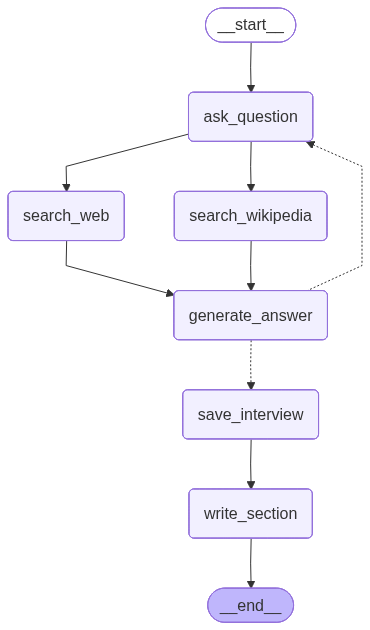

In [92]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [93]:
analyst

Analyst(name='Raj Patel', role='Software Developer Advocate', affiliation='Open Source AI Community', description='Raj is passionate about the developer experience with Langgraph. He explores how Langgraph can empower developers by providing robust tools and resources. His concern is to ensure that Langgraph remains accessible and user-friendly for developers of all skill levels, fostering innovation and collaboration.')

In [94]:
analyst.persona


'Name: Raj Patel\nRole: Software Developer Advocate\nAffiliation: Open Source AI Community\nDescription: Raj is passionate about the developer experience with Langgraph. He explores how Langgraph can empower developers by providing robust tools and resources. His concern is to ensure that Langgraph remains accessible and user-friendly for developers of all skill levels, fostering innovation and collaboration.\n'

In [95]:
thread = {"configurable": {"thread_id": "1"}}


In [96]:
from IPython.display import Markdown


In [97]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]


In [98]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)


Yes i am checking messages  [HumanMessage(content='So you said you were writing an article on Langchain?', additional_kwargs={}, response_metadata={}, id='ef6e6f23-c160-49fd-9e76-88298b3718c7')] 
Yes i am checking analyst  Name: Raj Patel
Role: Software Developer Advocate
Affiliation: Open Source AI Community
Description: Raj is passionate about the developer experience with Langgraph. He explores how Langgraph can empower developers by providing robust tools and resources. His concern is to ensure that Langgraph remains accessible and user-friendly for developers of all skill levels, fostering innovation and collaboration.
 


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated question  ---->: Hello, I'm Alex, a tech journalist exploring the fascinating world of Langgraph. I'm particularly interested in how it empowers developers and fosters innovation. Raj, could you share some specific examples of how Langgraph has been used to solve real-world problems?


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Yes i am checking messages  [HumanMessage(content='So you said you were writing an article on Langchain?', additional_kwargs={}, response_metadata={}, id='ef6e6f23-c160-49fd-9e76-88298b3718c7'), AIMessage(content="Hello, I'm Alex, a tech journalist exploring the fascinating world of Langgraph. I'm particularly interested in how it empowers developers and fosters innovation. Raj, could you share some specific examples of how Langgraph has been used to solve real-world problems?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 243, 'total_tokens': 292, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CUKc17XvaieSn4CLx3xl2qPZUBWG6', 'service_tier': 'default', 'finish_reason': 'sto

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated question  ---->: Those are fascinating examples, Raj. Could you delve into how Langgraph ensures accessibility and user-friendliness for developers of varying skill levels? Are there specific features or resources that stand out in this regard?


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [99]:
Markdown(interview['sections'][0])


## Empowering Developers with LangGraph: A New Era of AI Application Development

### Summary

LangGraph is revolutionizing the developer experience by providing a robust framework for building complex AI applications. It empowers developers to create sophisticated, production-ready systems that are both scalable and reliable. The framework's graph-based approach allows for dynamic interactions and flexible control flows, making it an ideal tool for developers of all skill levels. This report explores the novel applications and insights gathered from various case studies and projects utilizing LangGraph.

LangGraph's versatility is evident in its wide range of applications, from customer service bots to manufacturing process automation. For instance, a healthcare provider successfully implemented an AI assistant for preliminary patient symptom analysis and triage, showcasing LangGraph's ability to handle real-world challenges [1]. Additionally, LangGraph's integration with other frameworks like LangChain and CrewAI enables developers to build multi-agent systems that can process complex data and make real-time decisions [2].

One of the most impactful features of LangGraph is its token-by-token streaming capability, which enhances user experience by providing real-time feedback. This feature is particularly beneficial for developer-facing applications, such as intelligent coding assistants and AI code review tools [3]. Moreover, LangGraph's automatic state management and error handling capabilities ensure that developers can focus on high-level logic without worrying about low-level scheduling or context management [4].

LangGraph's application in manufacturing demonstrates its potential to optimize processes by analyzing production data in real-time and suggesting enhancements. Its predictive maintenance capabilities help prevent failures and ensure seamless operations, highlighting its value in industrial settings [5]. Furthermore, LangGraph's ability to model workflows as graphs allows developers to create agentic applications with advanced control flows, such as loops and conditional branches, enabling more sophisticated AI behaviors [6].

In conclusion, LangGraph is a powerful tool that empowers developers to build innovative AI applications. Its user-friendly features and robust capabilities make it accessible to developers of all skill levels, fostering innovation and collaboration in the AI community. As LangGraph continues to evolve, it promises to bring even more possibilities to AI application development.

### Sources
[1] https://medium.com/@garima_yadav/real-world-applications-and-case-studies-with-langgraph-from-theory-to-practice-7a6ffd2e8e1b  
[2] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  
[3] https://www.gocodeo.com/post/getting-started-with-langgraph-a-practical-guide-for-ai-developers  
[4] https://www.designveloper.com/blog/what-is-langgraph/  
[5] https://www.indapoint.com/blog/langgraph-in-manufacturing-process-automation-revolutionizing-industry-with-intelligent-workflows.html  
[6] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications  

third Workflow


In [355]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [356]:
from langgraph.types import Send


In [357]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

In [362]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [361]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [360]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [359]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [358]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [363]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [364]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [365]:
memory = MemorySaver()


In [366]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)


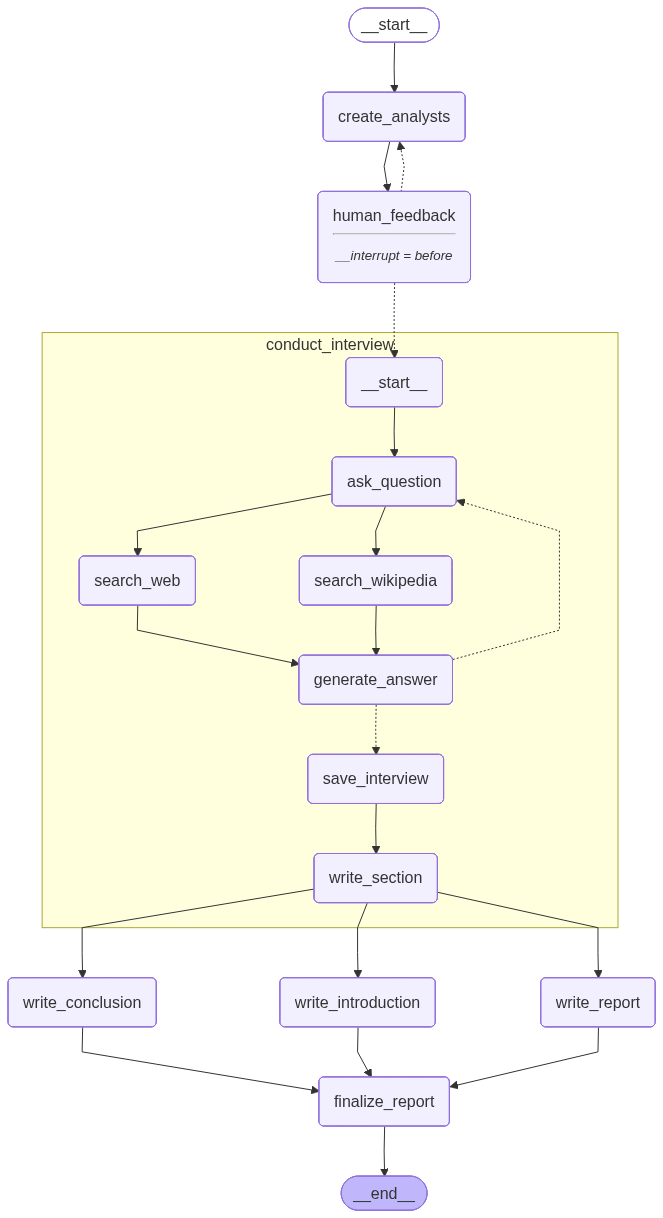

In [367]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
